In [1]:
import os
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
import matplotlib.pyplot as plt
from pygimli import meshtools as mt
from pygimli.physics import ert
from pygimli.physics import traveltime as tt
from SCCI import *
from JointEntropyClass import JointEntropyInversion as JEI
from    pygimli.viewer.mpl      import createColorBarOnly

# Load Data

21/07/23 - 14:43:26 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv
21/07/23 - 14:43:26 - pyGIMLi - INFO - Cache C:\Users\azieg\anaconda3\envs\pg\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (5.2s x 7): C:\Users\azieg\AppData\Roaming\pygimli\Cache\5631322072451977344


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2292f6d4790>)

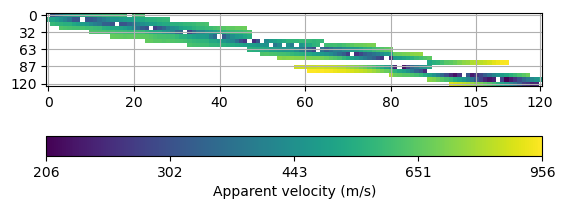

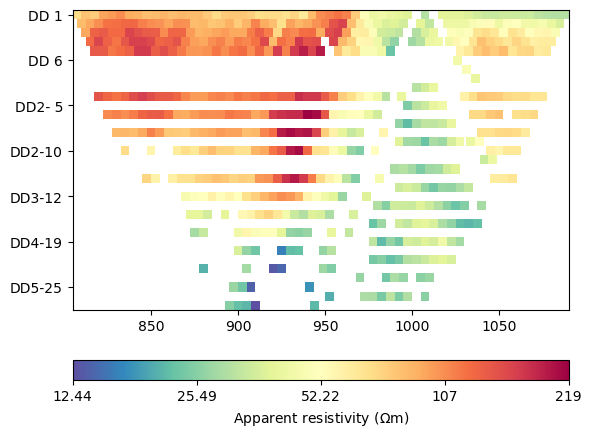

In [2]:
from pygimli import meshtools as mt
from pygimli.physics import ert
from pygimli.physics import traveltime as tt


SRT = tt.load('P3_2_Joint.sgt')
TT = tt.TravelTimeManager(SRT, verbose=True)
tt.errIsAbsolute = True
TT.data["t"] /= 1000 # convert in milisecond
TT.showData()

ERT = ert.load('ERT_3_2_Joint.dat')
sensor_pos = np.loadtxt('ERT_3_2_Sensors_Joint.txt',delimiter=',')
ERT.setSensorPositions(sensor_pos)

ERT['k'] = ert.createGeometricFactors(ERT, numerical=True)
ERT['err'] = ert.estimateError(ERT, absoluteUError=5e-5, relativeError=0.03)
mgr = ert.ERTManager(ERT)
ert.show(ERT, cMin=min(ERT['rhoa']), cMax = max(ERT['rhoa']))

# Conventional Inversions

In [ ]:
invmesh = TT.createMesh(SRT,paraMaxCellSize=5.0,paraDepth=50)
extmesh = mt.appendTriangleBoundary(invmesh,xbound=10,ybound=0,marker=1)

v_est = TT.invert(SRT, mesh=extmesh, lam = 65, vTop = 250, vBottom = 2000)

21/07/23 - 14:43:30 - pyGIMLi - INFO - Found 1 regions.
21/07/23 - 14:43:31 - pyGIMLi - ERROR - <class 'pygimli.physics.traveltime.TravelTimeManager.TravelTimeManager'>.checkError(C:\Users\azieg\anaconda3\envs\pg\lib\site-packages\pygimli\physics\traveltime\TravelTimeManager.py:96)
DataContainer has no "err" values. Fallback to 3%
21/07/23 - 14:43:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
21/07/23 - 14:43:31 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.


In [ ]:
r_est = mgr.invert(lam=30, zWeight=0.5, secNodes=3, verbose=True, paraDepth=50, blockymodel=True, mesh = extmesh)

In [ ]:
plt.rcParams['font.size'] = 16
rKW = dict(logScale=True, cMin=10, cMax=800, ylabel="m asl.", cMap = 'magma',# coverage = mgr.standardizedCoverage(threshold=-2), 
           orientation="vertical", showTopo = True, label = r"$\rho$ ($\Omega$m)")
vKW = dict(logScale=False, cMin=150, cMax=2500, ylabel = "m asl.",# coverage = TT.standardizedCoverage(), 
           orientation = 'vertical', cMap = 'viridis', label = r"$v_p$ (m/s)")

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (20,8), gridspec_kw={'hspace':-.4}, sharex=True)
mgr.showResult(ax=ax1, **rKW)
ax1.axis(xmin = 800, xmax=1100,ymin=125,ymax=155)
#drawCWeight(ax1, mgr.paraDomain, mgr.inv.inv.cWeight())
TT.showResult(ax=ax2, **vKW)
ax2.axis(xmin = 800, xmax=1100,ymin=125,ymax=155)
#drawCWeight(ax2, TT.paraDomain, TT.inv.inv.cWeight())
fig.tight_layout()


# SCCI (Skibbe)

0.2984124161657807 0.34063754490636017 0.8324005817501957 0.9221339136508933
Coupled inversion 1
Coupled inversion 2
Coupled inversion 3
Coupled inversion 4
Coupled inversion 5
0.34063754490636017 0.2984124161657807


C:\Users\azieg\AppData\Local\Temp\ipykernel_15064\708984855.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


The chi² values of ERT and SRT are 1.4471064547501964 and 0.5498466474827425


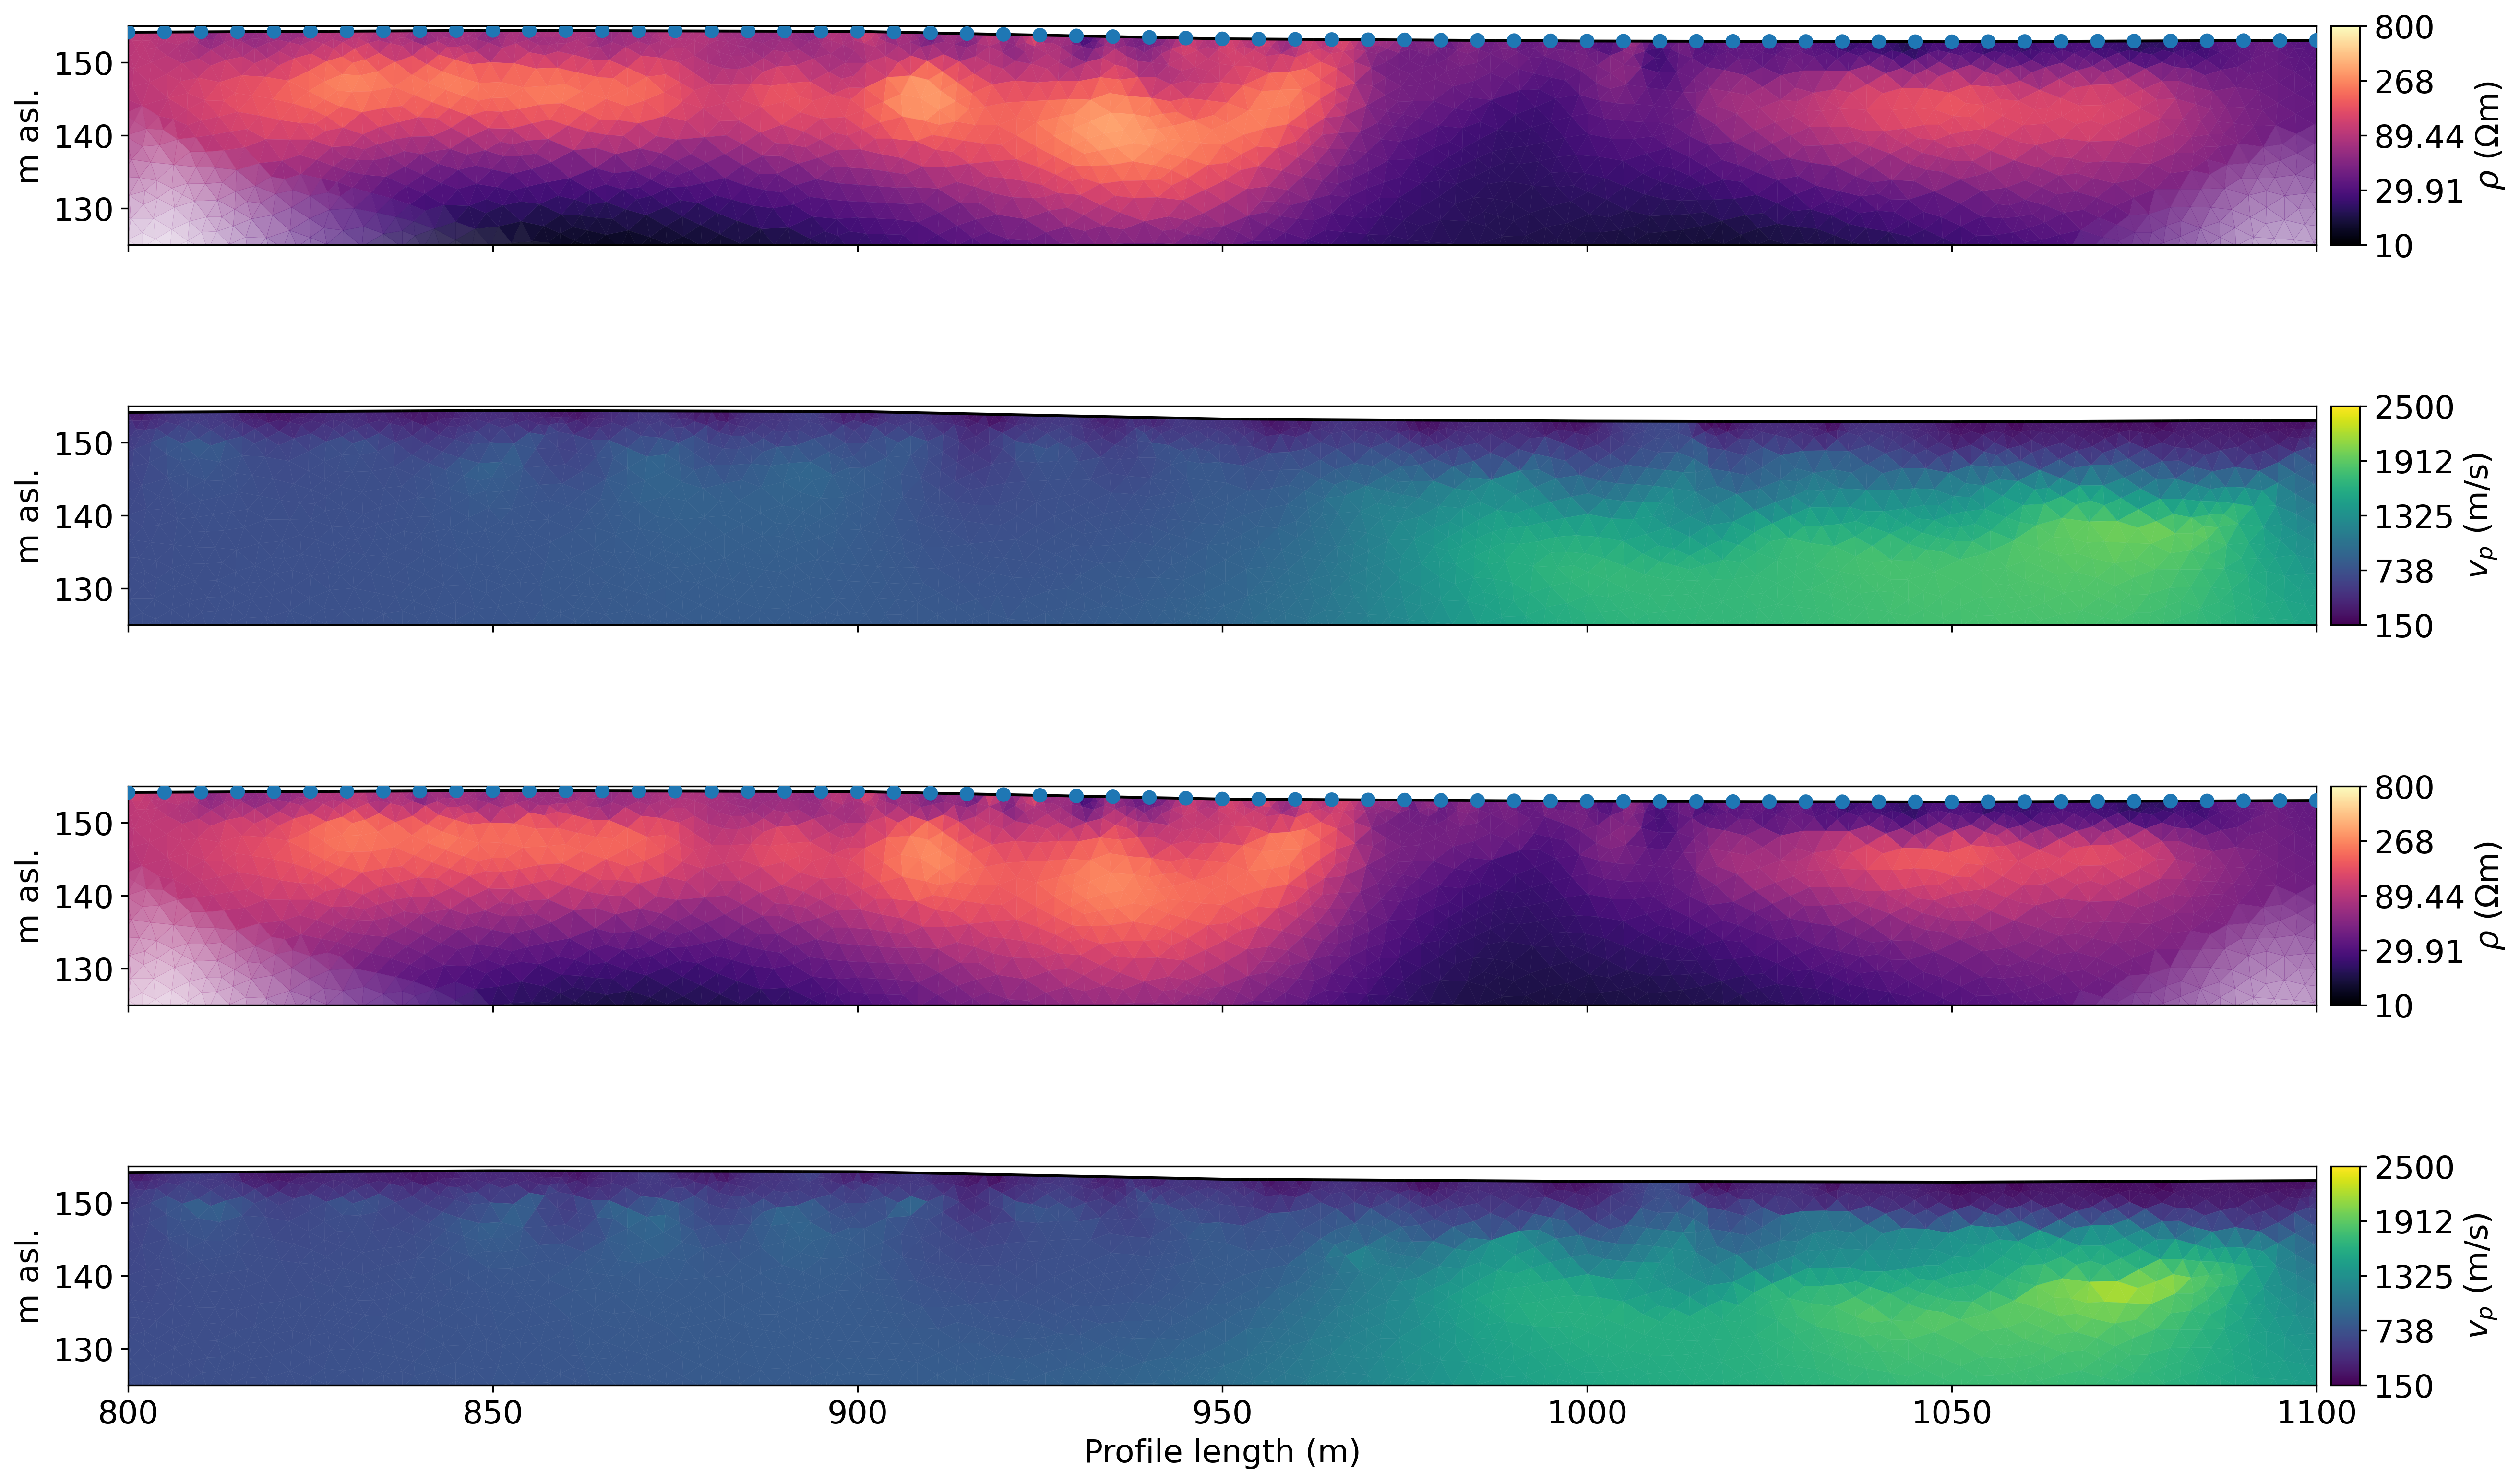

In [6]:
par_a = np.arange(0.05, 0.45, 0.05)

# %% setup scci class and give manager
scci = SCCI([mgr, TT], names=["ERT", "TT"])

scci.a = 0.1
scci.b = 0.15
scci.c = 1.0
scci.cmin = scci.b

# %%
cw = scci.singleCWeights()
print(min(cw[0]), min(cw[1]), np.mean(cw[0]), np.mean(cw[1]))


fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(20,16), dpi=300,  gridspec_kw={'hspace':-.4}, sharex=True)

mgr.showResult(ax=ax1, **rKW)
ax1.axis(xmin = 800, xmax=1100,ymin=125,ymax=155)

TT.showResult(ax=ax2,**vKW)
ax2.axis(xmin = 800, xmax=1100,ymin=125,ymax=155)

# %%
scci.runCoupled(maxIter=5)
print(min(mgr.inv.inv.cWeight()), min(TT.inv.inv.cWeight()))
# %%

mgr.inv.model = mgr.inv.inv.model()
r_est_scci = mgr.inv.inv.model()

TT.inv.model = 1./TT.inv.inv.model()
v_est_scci =  1./TT.inv.inv.model()
# %%
mgr.showResult(ax=ax3, **rKW)
#drawCWeight(ax3, mgr.paraDomain, mgr.inv.inv.cWeight())
ax3.axis(xmin = 800, xmax=1100,ymin=125,ymax=155)
#plt.savefig("ERT_coupled.png")
TT.showResult(ax=ax4,**vKW)
#drawCWeight(ax4, TT.paraDomain, TT.inv.inv.cWeight())
ax4.axis(xmin = 800, xmax=1100,ymin=125,ymax=155)
ax4.set_xlabel("Profile length (m)")
#plt.savefig("TT_coupled.png")
fig.tight_layout()

#plt.savefig("F:/Doktor/Poster/P3_2_right.png", dpi = 300)

print("The chi² values of ERT and SRT are", mgr.inv.chi2(), "and", TT.inv.chi2())

# Joint Minimum Entropy Inversion

## Pre-Inversion Setups

21/07/23 - 13:25:10 - pyGIMLi - INFO - could not read unified data format for ERT ... try res2dinv
21/07/23 - 13:25:10 - pyGIMLi - INFO - Cache C:\Users\azieg\anaconda3\envs\pg\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (5.2s x 6): C:\Users\azieg\AppData\Roaming\pygimli\Cache\5631322072451977344


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2936f565c10>)

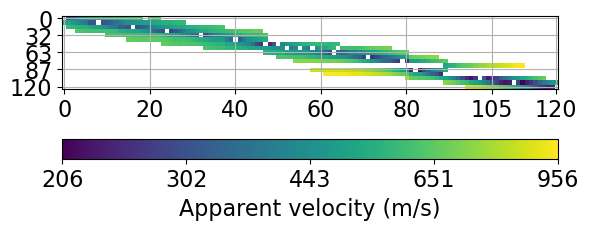

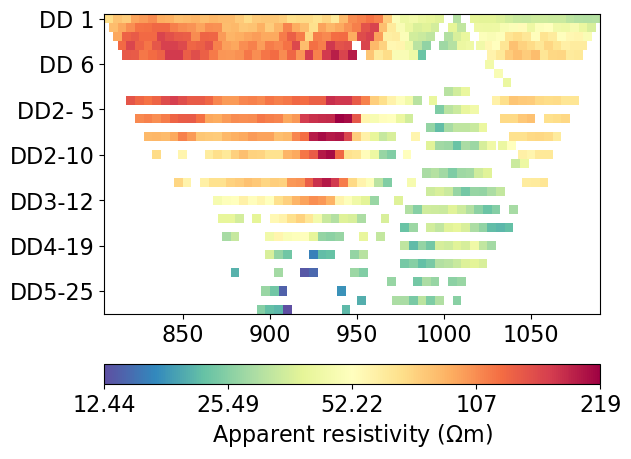

In [8]:
# SRT Data manager
tt_data = tt.load('P3_2_Joint.sgt')
TT_J = tt.TravelTimeManager(tt_data, verbose=True)
tt.errIsAbsolute = True
TT_J.data["t"] /= 1000 # convert in milisecond

# ERT Data manager
ert_data = ert.load('ERT_3_2_Joint.dat')
ert_data.setSensorPositions(sensor_pos)
ert_data['k'] = ert.createGeometricFactors(ert_data, numerical=True)
ert_data['err'] = ert.estimateError(ert_data, absoluteUError=5e-5, relativeError=0.03)
ERT_J = ert.ERTManager(ert_data)

TT_J.showData()
ert.show(ert_data, cMin=min(ert_data['rhoa']), cMax = max(ert_data['rhoa']))

## JME Inversion Manager

Maybe use my synthetic data study to find good settings (see PDFs in zip):



<img align="left" src="./Comp_ME_lam_a_q1_ERT.pdf">
<img align="left" src="./Comp_ME_lam_a_q2_ERT.pdf">
<img align="left" src="./Comp_ME_lam_a_q1_SRT.pdf">
<img align="left" src="./Comp_ME_lam_a_q2_SRT.pdf">

In [9]:
# JME parameters
q=1
beta = 1e-10

lam_ert = 1e-3
a_ert = 30

lam_srt = 5e-2
a_srt = 20

In [ ]:
# Set Parameters
a = [a_ert, a_srt]
lam = [lam_ert, lam_srt]
beta = beta
w1 = 1 # weight ert
w2 = 1 # weight srt

# Initiate Maager
J1 = JEI(mgr_list=[ERT_J,TT_J], data_list=[ERT,SRT], 
         mesh=extmesh, order=q, beta=beta,smooth_factor=a)

# Set Pre-Inversion stuff
KWs = dict(lam=lam[1], verbose=False, vTop = 200, vBottom = 2000, secNodes=2)
KWe = dict(lam=lam[0], verbose=False, zWeight=0.5, blockymodel=True, startModel=100)
# J1.setMethodMesh(extmesh, 0)
J1.setKWInv([KWe, KWs])
J1.setNames(['ERT','SRT'])
J1.setMethodWeights([w1,w2])

# Run inversion
J1.runInversion('ME', maxIter=10, breakup_criterion='all', chi_limit=1)
TT_J.inv.model = 1/TT_J.inv.model

[r_est_jme, v_est_jme] = J1.getModels()
    
J1.plotFitHistory()

21/07/23 - 14:04:01 - pyGIMLi - INFO - Found 1 regions.
21/07/23 - 14:04:01 - pyGIMLi - INFO - Creating forward mesh from region infos.


Starting Iteration 0...
... ERT


21/07/23 - 14:04:01 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
21/07/23 - 14:04:02 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 12040 Cells: 23276 Boundaries: 17858


# Show results

In [15]:
%matplotlib qt

plt.rcParams['font.size'] = 10
rKW = dict(logScale=True, cMin=10, cMax=800, ylabel="m asl.", cMap = 'magma',# coverage = ERT_J.standardizedCoverage(threshold=-2.2),
          showTopo = True, label = r"$\rho$ ($\Omega$m)", orientation='vertical')
vKW = dict(logScale=False, cMin=150, cMax=2500, ylabel = "m asl.",# coverage = TT_J.standardizedCoverage(),
           cMap = 'viridis', label = r"$v_p$ (m/s)", orientation='vertical')

fig, ax = plt.subplots(6,1,figsize=(20,16),sharex=True)#,  gridspec_kw={'hspace':-.4})

r = [r_est, r_est_scci, r_est_jme]
v = [v_est, v_est_scci, v_est_jme]
label = ['Conventional','SCCI','JME']

for i in [0,1,2]:
    pg.show(invmesh, r[i], ax=ax[i], **rKW)
    pg.show(invmesh, v[i], ax=ax[i+3], **vKW)
        
    for axis in [ax[i],ax[i+3]]:
        axis.text(803, 130, label[i], fontsize=10, 
                  bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
    
for axis in ax:
    axis.axis(xmin = 800, xmax=1100,ymin=125,ymax=155)
    
ax[-1].set_xlabel("Profile length (m)", fontsize=10)
        
fig.tight_layout()


    

In [14]:
# This plots modelweights of iterations of all methods with the log-part that is shared by all methods
# J1.plotWeights('ME', step=2)